# Install Required packages

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! python -m pip install --upgrade pip

In [5]:
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip3 install --upgrade

Cloning into 'transformers'...
remote: Enumerating objects: 265790, done.
remote: Counting objects: 100% (394/394), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 265790 (delta 313), reused 251 (delta 251), pack-reused 265396 (from 3)
Receiving objects: 100% (265790/265790), 277.07 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (196696/196696), done.
ERROR: You must give at least one requirement to install (see "pip help install")


In [6]:
! pip install seqeval

  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=6bbb3657dc6840252a25d112091548c40a82fe194d0a5cab7862d79ae4701f4a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [7]:
! pip3 install py_vncorenlp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4305 sha256=60df50573eb1474a2409c84d24c65a3a13392d774a348320ae07bec5ab5db4d2
  Stored in directory: /root/.cache/pip/wheels/6d/2d/d6/158260bfd6820d144535857b80cc112bee5c3aa6d81b6dc049
Successfully built py_vncorenlp


In [8]:
! mkdir -p vncorenlp/models/wordsegmenter
! wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar -P vncorenlp/
! wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab -P vncorenlp/models/wordsegmenter/
! wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr -P vncorenlp/models/wordsegmenter/


--2025-03-27 04:13:34--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘vncorenlp/VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.09s   

2025-03-27 04:13:35 (297 MB/s) - ‘vncorenlp/VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2025-03-27 04:13:35--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

In [9]:
! pip install transformers sentencepiece protobuf


# Import Libraries

In [10]:
import os
import json
import numpy as np
import torch
import py_vncorenlp
import transformers
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from py_vncorenlp import VnCoreNLP, download_model

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import json
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer


# Convert and Load Data

In [ ]:
def fix_json_format(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    data = [json.loads(line) for line in lines]

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

    print(f"Fixed JSON file saved to {output_path}")

fix_json_format("/content/drive/MyDrive/data/train_word.json", "/content/drive/MyDrive/data/train_word_fixed.json")
fix_json_format("/content/drive/MyDrive/data/test_word.json", "/content/drive/MyDrive/data/test_word_fixed.json")

Fixed JSON file saved to /content/drive/MyDrive/data/train_word_fixed.json
Fixed JSON file saved to /content/drive/MyDrive/data/test_word_fixed.json


# Model training

In [ ]:
transformers.logging.set_verbosity_error()

class NERDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, label_map):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = label_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words = self.data[idx]['words']
        tags = self.data[idx]['tags']

        encodings = self.tokenizer(
            words,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        label_ids = np.ones(self.max_len, dtype=int) * -100

        for i, token_id in enumerate(encodings['input_ids'][0]):
            if token_id in [self.tokenizer.cls_token_id, self.tokenizer.sep_token_id, self.tokenizer.pad_token_id]:
                continue

            word_idx = self._find_word_index(words, encodings['input_ids'][0], i)

            if word_idx is not None and word_idx < len(tags):
                label_ids[i] = self.label_map[tags[word_idx]]

        return {
            'input_ids': encodings['input_ids'][0],
            'attention_mask': encodings['attention_mask'][0],
            'labels': torch.tensor(label_ids)
        }

    def _find_word_index(self, words, tokens, token_index):
        for word_idx, word in enumerate(words):
            word_tokens = self.tokenizer.tokenize(word)

            if tokens[token_index] in [self.tokenizer.convert_tokens_to_ids(t) for t in word_tokens]:
                return word_idx

        return None

def create_label_map(data):
    all_labels = set()
    for item in data:
        all_labels.update(item['tags'])

    label_map = {label: idx for idx, label in enumerate(sorted(all_labels))}
    reverse_label_map = {idx: label for label, idx in label_map.items()}

    return label_map, reverse_label_map

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)  # Convert logits to label indices

    true_labels = [[str(label) for label in label_row if label != -100] for label_row in labels]
    pred_labels = [[str(pred) for pred, label in zip(pred_row, label_row) if label != -100]
                   for pred_row, label_row in zip(predictions, labels)]

    return {
        "precision": precision_score(true_labels, pred_labels),
        "recall": recall_score(true_labels, pred_labels),
        "f1": f1_score(true_labels, pred_labels),
    }

def train_phobert_ner(train_path, test_path, model_name='vinai/phobert-base', max_len=256, output_dir='./phobert_ner'):
    with open(train_path, "r", encoding="utf-8") as f:
        train_data = json.load(f)
    with open(test_path, "r", encoding="utf-8") as f:
        test_data = json.load(f)

    label_map, reverse_label_map = create_label_map(train_data)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name, num_labels=len(label_map), id2label=reverse_label_map, label2id=label_map
    )

    train_dataset = NERDataset(train_data, tokenizer, max_len, label_map)
    test_dataset = NERDataset(test_data, tokenizer, max_len, label_map)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=4,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=8,
        warmup_steps=150,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print("Evaluation Results:", eval_results)

    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    return output_dir, reverse_label_map


def main():
    TRAIN_PATH = '/content/drive/MyDrive/data/train_word_fixed.json'
    TEST_PATH = '/content/drive/MyDrive/data/test_word_fixed.json'
    VNCORENLP_PATH = '/content/vncorenlp'

    # Train and save the model
    model_dir, label_map = train_phobert_ner(TRAIN_PATH, TEST_PATH)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 3.0122, 'grad_norm': 5.811668395996094, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.007955449482895784}
{'loss': 2.7831, 'grad_norm': 5.088693141937256, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.015910898965791568}
{'loss': 2.3072, 'grad_norm': 6.366656303405762, 'learning_rate': 1e-05, 'epoch': 0.02386634844868735}
{'loss': 1.5853, 'grad_norm': 2.8981897830963135, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.031821797931583136}
{'loss': 1.1271, 'grad_norm': 1.8294801712036133, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.03977724741447892}
{'loss': 1.0075, 'grad_norm': 1.3789408206939697, 'learning_rate': 2e-05, 'epoch': 0.0477326968973747}
{'loss': 1.0383, 'grad_norm': 1.816556692123413, 'learning_rate': 2.3333333333333336e-05, 'epoch': 0.05568814638027048}
{'loss': 0.8081, 'grad_norm': 3.319821834564209, 'learning_rate': 2.6666666666666667e-05, 'epoch': 0.06364359586316627}
{'loss': 0.7804, 'grad_norm': 1.6250989437103271, 'learning_rate': 3e-

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 19 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 11 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 5 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning

{'eval_loss': 0.15593703091144562, 'eval_precision': 0.8962505325948019, 'eval_recall': 0.8932872266205599, 'eval_f1': 0.8947664261298899, 'eval_runtime': 101.9915, 'eval_samples_per_second': 29.414, 'eval_steps_per_second': 3.677, 'epoch': 1.0}
{'loss': 0.094, 'grad_norm': 5.520149230957031, 'learning_rate': 3.862238622386224e-05, 'epoch': 1.0023866348448687}
{'loss': 0.0544, 'grad_norm': 0.5998801589012146, 'learning_rate': 3.851988519885199e-05, 'epoch': 1.0103420843277646}
{'loss': 0.1058, 'grad_norm': 4.509098529815674, 'learning_rate': 3.841738417384174e-05, 'epoch': 1.0182975338106603}
{'loss': 0.048, 'grad_norm': 0.9224710464477539, 'learning_rate': 3.831488314883149e-05, 'epoch': 1.026252983293556}
{'loss': 0.0558, 'grad_norm': 1.7387681007385254, 'learning_rate': 3.821238212382124e-05, 'epoch': 1.0342084327764518}
{'loss': 0.0772, 'grad_norm': 2.9099159240722656, 'learning_rate': 3.810988109881099e-05, 'epoch': 1.0421638822593478}
{'loss': 0.0529, 'grad_norm': 1.9658042192459

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 19 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 11 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 5 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning

{'eval_loss': 0.1255025416612625, 'eval_precision': 0.920298994124704, 'eval_recall': 0.9075135741802408, 'eval_f1': 0.9138615675972875, 'eval_runtime': 101.1807, 'eval_samples_per_second': 29.65, 'eval_steps_per_second': 3.706, 'epoch': 2.0}
{'loss': 0.0419, 'grad_norm': 0.6310327053070068, 'learning_rate': 2.570725707257073e-05, 'epoch': 2.0047732696897373}
{'loss': 0.0175, 'grad_norm': 0.020891908556222916, 'learning_rate': 2.5604756047560475e-05, 'epoch': 2.012728719172633}
{'loss': 0.0384, 'grad_norm': 0.029123859480023384, 'learning_rate': 2.5502255022550224e-05, 'epoch': 2.0206841686555292}
{'loss': 0.0086, 'grad_norm': 0.048545461148023605, 'learning_rate': 2.5399753997539977e-05, 'epoch': 2.028639618138425}
{'loss': 0.0106, 'grad_norm': 0.024783404543995857, 'learning_rate': 2.529725297252973e-05, 'epoch': 2.0365950676213207}
{'loss': 0.0453, 'grad_norm': 0.21264293789863586, 'learning_rate': 2.5194751947519475e-05, 'epoch': 2.0445505171042164}
{'loss': 0.05, 'grad_norm': 0.13

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 19 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 11 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 5 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning

{'eval_loss': 0.10978832840919495, 'eval_precision': 0.9340716652349982, 'eval_recall': 0.9235599235599236, 'eval_f1': 0.9287860531092231, 'eval_runtime': 101.5046, 'eval_samples_per_second': 29.555, 'eval_steps_per_second': 3.694, 'epoch': 3.0}
{'loss': 0.0203, 'grad_norm': 1.4617279767990112, 'learning_rate': 1.2792127921279212e-05, 'epoch': 3.007159904534606}
{'loss': 0.0459, 'grad_norm': 0.8136143684387207, 'learning_rate': 1.2689626896268964e-05, 'epoch': 3.015115354017502}
{'loss': 0.0083, 'grad_norm': 0.09863249957561493, 'learning_rate': 1.2587125871258711e-05, 'epoch': 3.023070803500398}
{'loss': 0.0146, 'grad_norm': 0.5347081422805786, 'learning_rate': 1.2484624846248464e-05, 'epoch': 3.0310262529832936}
{'loss': 0.0204, 'grad_norm': 1.5665639638900757, 'learning_rate': 1.2382123821238213e-05, 'epoch': 3.0389817024661894}
{'loss': 0.0153, 'grad_norm': 1.1000386476516724, 'learning_rate': 1.2279622796227964e-05, 'epoch': 3.046937151949085}
{'loss': 0.0654, 'grad_norm': 0.01221

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 19 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 11 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 5 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning

{'eval_loss': 0.10976196080446243, 'eval_precision': 0.9325459637160599, 'eval_recall': 0.9292929292929293, 'eval_f1': 0.9309166046278431, 'eval_runtime': 101.802, 'eval_samples_per_second': 29.469, 'eval_steps_per_second': 3.684, 'epoch': 4.0}
{'train_runtime': 1928.9627, 'train_samples_per_second': 10.424, 'train_steps_per_second': 2.607, 'train_loss': 0.09074393045653603, 'epoch': 4.0}


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 19 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 11 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 5 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning

{'eval_loss': 0.10976196080446243, 'eval_precision': 0.9325459637160599, 'eval_recall': 0.9292929292929293, 'eval_f1': 0.9309166046278431, 'eval_runtime': 114.8668, 'eval_samples_per_second': 26.117, 'eval_steps_per_second': 3.265, 'epoch': 4.0}
Evaluation Results: {'eval_loss': 0.10976196080446243, 'eval_precision': 0.9325459637160599, 'eval_recall': 0.9292929292929293, 'eval_f1': 0.9309166046278431, 'eval_runtime': 114.8668, 'eval_samples_per_second': 26.117, 'eval_steps_per_second': 3.265, 'epoch': 4.0}


# Model Evaluation

Final true_labels count: 24870
Final pred_probs count: 24870


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Per-Entity F1 Scores:
                     precision    recall  f1-score
AGE                   0.989324  0.939189  0.963605
DATE                  0.991523  0.988550  0.990034
GENDER                1.000000  0.981273  0.990548
JOB                   0.986425  0.741497  0.846602
LOCATION              0.981904  0.949543  0.965452
NAME                  0.978224  0.940419  0.958949
O                     0.000000  0.000000  0.000000
ORGANIZATION          0.962101  0.906926  0.933699
PATIENT_ID            0.997504  0.985210  0.991319
SYMPTOM_AND_DISEASE   0.998339  0.890370  0.941269
TRANSPORTATION        0.990792  0.978182  0.984446


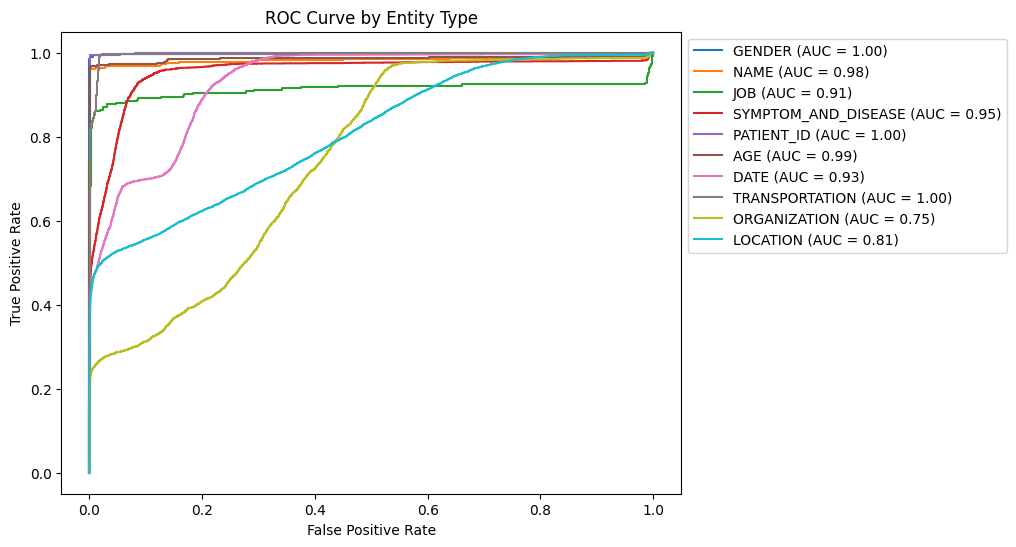

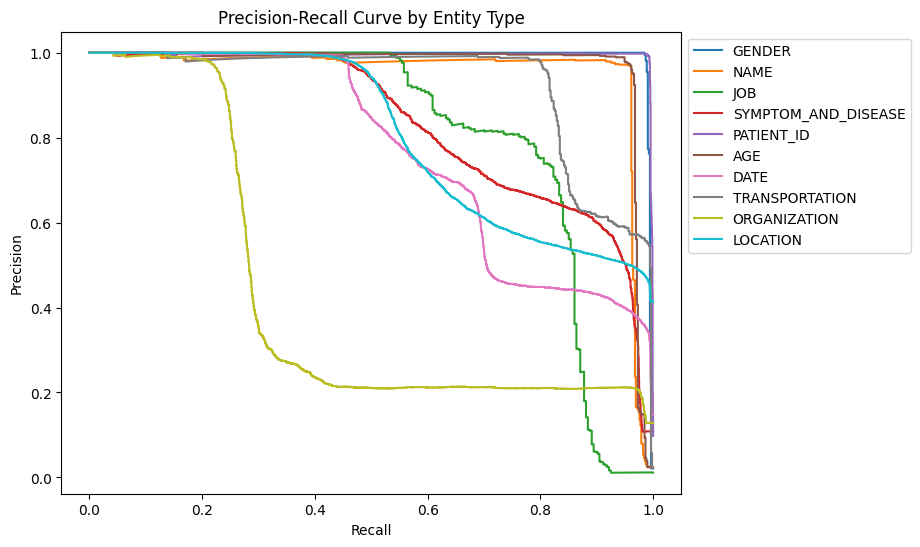

In [ ]:
MODEL_DIR = '/content/phobert_ner'
TRAIN_PATH = '/content/drive/MyDrive/data/train_word_fixed.json'
TEST_PATH = '/content/drive/MyDrive/data/test_word_fixed.json'

def load_trained_model(model_dir):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForTokenClassification.from_pretrained(model_dir)
    return model, tokenizer

def map_to_entity(labels, label_map):
    entity_labels = []

    for label in labels:
        try:
            tag = list(label_map.keys())[list(label_map.values()).index(label)]
            if tag == 'O':
                entity_labels.append('O')  # Include 'O' to maintain consistency
                continue
            entity = tag.split('-')[-1] if '-' in tag else tag
            entity_labels.append(entity)
        except ValueError:
            print(f"Warning: Label {label} not found in label_map!")

    return entity_labels

def run_inference(model, tokenizer, test_dataset):
    trainer = Trainer(model=model)
    raw_preds = trainer.predict(test_dataset)
    logits, labels = raw_preds.predictions, raw_preds.label_ids
    probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)

    true_labels, pred_probs = [], []

    for label_row, prob_row in zip(labels, probs):
        for label, prob in zip(label_row, prob_row):
            if label == -100:  
                continue

            tag = list(label_map.keys())[list(label_map.values()).index(label)]
            if tag == 'O': 
                continue

            true_labels.append(label)
            pred_probs.append(prob[:len(label_map)])

    print(f"Final true_labels count: {len(true_labels)}")
    print(f"Final pred_probs count: {len(pred_probs)}")

    return np.array(true_labels), np.array(pred_probs)

def calculate_f1_per_entity(true_labels, pred_probs, label_map):
    pred_labels = np.argmax(pred_probs, axis=1)

    true_entities = map_to_entity(true_labels, label_map)
    pred_entities = map_to_entity(pred_labels, label_map)

    report = classification_report(true_entities, pred_entities, output_dict=True)
    df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']]
    df = df.drop(index=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    print("\nPer-Entity F1 Scores:")
    print(df)
    return df

def plot_roc_pr_curves(true_labels, pred_probs, label_map):
    entity_types = set(map_to_entity(label_map.values(), label_map)) - {'O'}
    plt.figure(figsize=(8, 6))

    for entity in entity_types:
        binary_true_labels = np.array([1 if map_to_entity([lbl], label_map)[0] == entity else 0 for lbl in true_labels])
        binary_pred_probs = np.array([prob[label_map[f'B-{entity}']] if f'B-{entity}' in label_map else 0 for prob in pred_probs])

        if sum(binary_true_labels) == 0:
            continue  

        fpr, tpr, _ = roc_curve(binary_true_labels, binary_pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{entity} (AUC = {roc_auc:.2f})')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve by Entity Type")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(False)
    plt.show()

    plt.figure(figsize=(8, 6))
    for entity in entity_types:
        binary_true_labels = np.array([1 if map_to_entity([lbl], label_map)[0] == entity else 0 for lbl in true_labels])
        binary_pred_probs = np.array([prob[label_map[f'B-{entity}']] if f'B-{entity}' in label_map else 0 for prob in pred_probs])

        if sum(binary_true_labels) == 0:
            continue  

        precision, recall, _ = precision_recall_curve(binary_true_labels, binary_pred_probs)
        plt.plot(recall, precision, label=entity)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve by Entity Type")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(False)
    plt.show()

model, tokenizer = load_trained_model(MODEL_DIR)

with open(TEST_PATH, "r", encoding="utf-8") as f:
    test_data = json.load(f)

with open(TRAIN_PATH, "r", encoding="utf-8") as f:
    train_data = json.load(f)

all_labels = set()
for item in train_data:
    all_labels.update(item['tags'])
label_map = {label: idx for idx, label in enumerate(sorted(all_labels))}

if 'O' not in label_map:
    label_map['O'] = len(label_map)

test_dataset = NERDataset(test_data, tokenizer, max_len=256, label_map=label_map)

true_labels, pred_probs = run_inference(model, tokenizer, test_dataset)

calculate_f1_per_entity(true_labels, pred_probs, label_map)

plot_roc_pr_curves(true_labels, pred_probs, label_map)


# Model Demo and Testing

## Functions
Tokenize and Predict model

In [ ]:
def tokenize_with_vncorenlp(sentences, vncorenlp_path):
    """
    Tokenizes sentences using VnCoreNLP.

    Args:
        sentences (list): List of sentences to tokenize.
        vncorenlp_path (str): Path to VnCoreNLP directory.

    Returns:
        list: Tokenized sentences.
    """
    if not os.path.exists(vncorenlp_path + "/models"):
        print("Downloading VnCoreNLP model...")
        download_model(save_dir=vncorenlp_path)
    else:
        print("VnCoreNLP model already exists. Skipping download.")

    annotator = VnCoreNLP(save_dir=vncorenlp_path, annotators=["wseg"])

    tokenized_sentences = []
    for sentence in sentences:
        output = annotator.word_segment(sentence)  
        tokenized_sentences.append(output)

    return tokenized_sentences

def predict_ner(tokenized_sentences, model_dir):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)  
    model = AutoModelForTokenClassification.from_pretrained(model_dir)
    model.eval()

    results = []

    for tokens in tokenized_sentences:
        encodings = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)

        with torch.no_grad():
            outputs = model(**encodings)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=2).squeeze().tolist()

        id2label = model.config.id2label

        words = []
        tags = []

        for idx, token in enumerate(encodings.input_ids.squeeze().tolist()):
            word = tokenizer.decode([token])  
            words.append(word)
            tags.append(id2label.get(predictions[idx], "O"))

        results.append({"words": words, "tags": tags})

    return results


## Data Preprocessing - Tokenization

In [ ]:
test_sentences = [
    "Bệnh nhân A 25 tuổi quê quán Vĩnh Phúc đang điều trị tại bệnh viện Hà Nội",
    "Bộ Y tế đang chỉ đạo các biện pháp phòng chống dịch COVID-19"
]

In [ ]:
VNCORENLP_PATH = '/content/drive/MyDrive'  

tokenized_sentences = tokenize_with_vncorenlp(test_sentences, VNCORENLP_PATH)

for sentence, tokenized_sentence in zip(test_sentences, tokenized_sentences):
    print("\nOriginal Sentence:", sentence)
    print("Tokenized Sentence:", " ".join(tokenized_sentence))



Original Sentence: Bệnh nhân A 25 tuổi quê quán Vĩnh Phúc đang điều trị tại bệnh viện Hà Nội
Tokenized Sentence: Bệnh_nhân A 25 tuổi quê_quán Vĩnh_Phúc đang điều_trị tại bệnh_viện Hà_Nội

Original Sentence: Bộ Y tế đang chỉ đạo các biện pháp phòng chống dịch COVID-19
Tokenized Sentence: Bộ Y_tế đang chỉ_đạo các biện_pháp phòng_chống dịch COVID-19


## Model output

In [ ]:
MODEL_DIR = "/content/phobert_ner"  


test_predictions = predict_ner(tokenized_sentences, MODEL_DIR)

for sentence, prediction in zip(test_sentences, test_predictions):
    print("\nOriginal Sentence:", sentence)
    print("NER Predictions:", prediction)


Original Sentence: Bệnh nhân A 25 tuổi quê quán Vĩnh Phúc đang điều trị tại bệnh viện Hà Nội
NER Predictions: {'words': ['<s>', 'Bệnh_nhân', 'A', '25', 'tuổi', 'quê_quán', 'Vĩnh_Phúc', 'đang', 'điều_trị', 'tại', 'bệnh_viện', 'Hà_Nội', '</s>'], 'tags': ['O', 'O', 'B-NAME', 'B-AGE', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O']}

Original Sentence: Bộ Y tế đang chỉ đạo các biện pháp phòng chống dịch COVID-19
NER Predictions: {'words': ['<s>', 'Bộ', 'Y_tế', 'đang', 'chỉ_đạo', 'các', 'biện_pháp', 'phòng_chống', 'dịch', 'CO@@', 'VI@@', 'D-@@', '19', '</s>'], 'tags': ['O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}
